In [1]:
#1.1.1
# Import SparkConf class into program by using similar code from tutorial
from pyspark import SparkConf
from pyspark import SparkContext 
from pyspark.sql import SparkSession 
# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
master = "local[*]"
# The `Assignment 2` shown on the Spark cluster UI page
app_name = "Assignment 2"
#1.1.2
spark_conf = SparkConf().setMaster(master).setAppName(app_name)
sc = SparkContext.getOrCreate(spark_conf)
sc.setLogLevel('ERROR')
spark = SparkSession(sc)

In [2]:
#1.2.1
#Loading each data file into two Dataframes
df_bureau = spark.read.csv("data/bureau.csv",header=True,inferSchema=True)
df_customer = spark.read.csv("data/customer.csv",header=True,inferSchema=True)

In [3]:
#Using cast(StringType()) to transform these column to String type
from pyspark.sql.types import StringType,IntegerType
df_customer = df_customer.withColumn("BranchID",df_customer.BranchID.cast(StringType()))
df_customer = df_customer.withColumn("AssetID",df_customer.AssetID.cast(StringType()))
df_customer = df_customer.withColumn("ManufacturerID",df_customer.ManufacturerID.cast(StringType()))
df_customer = df_customer.withColumn("SupplierID",df_customer.SupplierID.cast(StringType()))

In [4]:
#Using printScheme to display schema
df_bureau.printSchema()
df_customer.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- DATE-REPORTED: string (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-DT: string (nullable = true)
 |-- CLOSE-DT: string (nullable = true)
 |-- LAST-PAYMENT-DATE: string (nullable = true)
 |-- CREDIT-LIMIT/SANC AMT: string (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: string (nullable = true)
 |-- INSTALLMENT-AMT: string (nullable = true)
 |-- CURRENT-BAL: string (nullable = true)
 |-- INSTALLMENT-FREQUENCY: string (nullable = true)
 |-- OVERDUE-AMT: string (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)
 |-- ASSET_CLASS: string (nullable = true)
 |-- REPORTED DATE - HIST: string (nullable = true)
 |-- DPD - HIST: string (nullable = true)
 |-- CUR BAL - HIST: string (nulla

In [5]:
#Show row count of each dataframes
print(df_bureau.count())
print(df_customer.count())

624863
143400


In [6]:
#1.2.2
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import isnan, when, count, col

#Extract name of df_bureau column into list
columns_name = (df_bureau.columns)

#Create empty list
empty_l= []

#Using regexp_replace and for loop
for i in range(len(columns_name)):
    #filter if the column contain ','. It will remove ','
    if bool(df_bureau.filter(df_bureau[i].contains(',')).collect()) == True:
        df_bureau = df_bureau.withColumn(columns_name[i], F.regexp_replace(columns_name[i], ',', ''))
        empty_l.append(columns_name[i])
        

#Remove '\' from column INSTALLMENT-AMT 
df_bureau = df_bureau.withColumn("INSTALLMENT-AMT",regexp_replace(col("INSTALLMENT-AMT"),"(\D)",""))

#Change column type to Integer
for i in range(len(empty_l)): 
    df_bureau = df_bureau.withColumn(empty_l[i],col(empty_l[i]).cast(IntegerType()))   


In [7]:
#1.2.3
#Show number of row that contain a null value
df_customer.subtract(df_customer.dropna()).count()

22092

In [8]:
#Remove row that contain any null value
df_customer = df_customer.dropna()

In [9]:
#1.2.4
#Create new column that is the sum of null 
column_null = df_bureau.select([count(when(col(c).isNull() , c)).alias(c) for c in df_bureau.columns])
#Check if percentage of null is larger than 20% or not
for i in range(len(df_bureau.columns)):   
     column_null.select(column_null[i],((column_null[i]/df_bureau.count())*100)).show()

+---+---------------------+
| ID|((ID / 624863) * 100)|
+---+---------------------+
|  0|                  0.0|
+---+---------------------+

+--------------+---------------------------------+
|SELF-INDICATOR|((SELF-INDICATOR / 624863) * 100)|
+--------------+---------------------------------+
|             0|                              0.0|
+--------------+---------------------------------+

+----------+-----------------------------+
|MATCH-TYPE|((MATCH-TYPE / 624863) * 100)|
+----------+-----------------------------+
|         0|                          0.0|
+----------+-----------------------------+

+---------+----------------------------+
|ACCT-TYPE|((ACCT-TYPE / 624863) * 100)|
+---------+----------------------------+
|        0|                         0.0|
+---------+----------------------------+

+----------------+-----------------------------------+
|CONTRIBUTOR-TYPE|((CONTRIBUTOR-TYPE / 624863) * 100)|
+----------------+-----------------------------------+
|               

In [10]:
#Drop column that percentage of null more than 20%
df_bureau = df_bureau.drop('CLOSE-DT','LAST-PAYMENT-DATE','CREDIT-LIMIT/SANC AMT','INSTALLMENT-AMT','INSTALLMENT-FREQUENCY','OVERDUE-AMT','ASSET_CLASS','REPORTED DATE - HIST','CUR BAL - HIST','AMT OVERDUE - HIST','AMT PAID - HIST','TENURE')

In [11]:
#1.2.5
import regex as re
column_list = df_bureau.columns
#Using regex to drop column that containing 'HIST', 'DATE' and 'DT'
r = re.compile(".*HIST|.*DATE|.*DT")
newlist = list(filter(r.match, column_list)) 
for i in range(len(newlist)):
    df_bureau = df_bureau.drop(newlist[i])
df_bureau.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: integer (nullable = true)
 |-- CURRENT-BAL: integer (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)



In [12]:
#1.3.1
#Filter only column datatype is numeric
columnList = [item[0] for item in df_bureau.dtypes if not item[1].startswith('string')]
#Remove column ID
columnList.remove('ID')
#Show count std,min,max of Bureau dataframe
df_bureau.select(columnList).summary("count","mean","stddev","min","max").show()

+-------+-------------------------+------------------+-----------------+
|summary|DISBURSED-AMT/HIGH CREDIT|       CURRENT-BAL|    WRITE-OFF-AMT|
+-------+-------------------------+------------------+-----------------+
|  count|                   624825|            624598|           603179|
|   mean|        316589.3861433201|103717.07101207497|291.3442643062839|
| stddev|       5176936.4467015965| 851087.5975786775|19561.75231589789|
|    min|                   -83878|         -20868956|              -30|
|    max|                999999999|         375991329|          8797356|
+-------+-------------------------+------------------+-----------------+



In [13]:
#Filter only column datatype is numeric
columnList = [item[0] for item in df_customer.dtypes if not item[1].startswith('string')]
#Remove column ID and ZiPCODE
columnList.remove('ID')
columnList.remove('ZiPCODE')
#Show count std,min,max of Customer dataframe
df_customer.select(columnList).summary("count","mean","stddev","min","max").show()

+-------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|            Tenure|        AssetCost|     AmountFinance|   DisbursalAmount|              EMI|              LTV|               AGE|     MonthlyIncome|
+-------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|  count|            121308|           121308|            121308|            121308|           121308|           121308|            121308|            121308|
|   mean| 42.75597652257065| 563289.852482936| 356361.5262638078| 356002.3838225838|56821.71514731098|59.62412924127061| 40.70355623701652|51901.613624659185|
| stddev|22.433473986085666|103558.8450100068|105717.74807158242|105537.25852397742|28585.22968535354|15.81841655789387|11.794657218312981|1774582.5522165233|
|    min|                 5|           200000|

In [14]:
#show top 10 of non-numeric column in Bureau dataframe
columnList = [item[0] for item in df_bureau.dtypes if item[1].startswith('string')]
for i in range(len(columnList)):
    placeholder = df_bureau.groupBy(columnList[i]).count()
    placeholder.orderBy(col("count").desc()).show(10)

+----------+------+
|MATCH-TYPE| count|
+----------+------+
|   PRIMARY|624638|
| SECONDARY|   225|
+----------+------+

+--------------------+------+
|           ACCT-TYPE| count|
+--------------------+------+
|        Tractor Loan|208051|
|           Gold Loan| 98602|
|Business Loan Pri...| 88274|
|   Kisan Credit Card| 37621|
|Auto Loan (Personal)| 33504|
|               Other| 31729|
|Commercial Vehicl...| 21296|
|    Two-Wheeler Loan| 17656|
|         Credit Card| 14397|
|       Consumer Loan| 13769|
+--------------------+------+
only showing top 10 rows

+----------------+------+
|CONTRIBUTOR-TYPE| count|
+----------------+------+
|             NBF|286311|
|             NAB|191368|
|             PRB| 84392|
|             COP| 26853|
|             RRB| 26374|
|             MFI|  3676|
|             HFC|  3174|
|             CCC|  1651|
|             FRB|   813|
|             SFB|   239|
+----------------+------+
only showing top 10 rows

+----------------+------+
|   OWNERSHIP-IND

In [15]:
#show top 10 of non-numeric column in Customer dataframe
columnList = [item[0] for item in df_customer.dtypes if item[1].startswith('string')]
#Remove Top-up Month column
columnList.remove('Top-up Month')
for i in range(len(columnList)):
    placeholder = df_customer.groupBy(columnList[i]).count()
    placeholder.orderBy(col("count").desc()).show(10)

+-----------+-----+
|  Frequency|count|
+-----------+-----+
|Half Yearly|78986|
|    Monthly|22535|
|    Quatrly|19482|
| BI-Monthly|  305|
+-----------+-----+

+-------------+------+
|InstlmentMode| count|
+-------------+------+
|       Arrear|116999|
|      Advance|  4309|
+-------------+------+

+----------+-----+
|LoanStatus|count|
+----------+-----+
|    Closed|86260|
|    Active|35048|
+----------+-----+

+------------+-----+
| PaymentMode|count|
+------------+-----+
|         ECS|33078|
|Direct Debit|32545|
|         PDC|25951|
|      Billed|17668|
|       PDC_E| 9398|
|  Auto Debit|  905|
|   SI Reject|  803|
|      Cheque|  489|
|  ECS Reject|  457|
|      Escrow|    7|
+------------+-----+
only showing top 10 rows

+--------+-----+
|BranchID|count|
+--------+-----+
|      24| 4534|
|     199| 4391|
|     166| 2464|
|      50| 2348|
|     202| 2234|
|     263| 2154|
|      41| 1935|
|     246| 1934|
|      85| 1854|
|     133| 1837|
+--------+-----+
only showing top 10 rows

+

In [16]:
#1.3.2

from pyspark.sql.functions import countDistinct

#Sum the rows for numeric type columns and add post fix _sum
a = df_bureau.groupby('ID').sum('DISBURSED-AMT/HIGH CREDIT','CURRENT-BAL','WRITE-OFF-AMT')\
.withColumnRenamed("sum(DISBURSED-AMT/HIGH CREDIT)","DISBURSED-AMT/HIGH CREDIT_sum")\
.withColumnRenamed("sum(CURRENT-BAL)","CURRENT-BAL_sum")\
.withColumnRenamed("sum(WRITE-OFF-AMT)","WRITE-OFF-AMT_sum")

#Count distinct value of non numeric columns and add post fix _dist
b = df_bureau.groupby('ID').agg(countDistinct('SELF-INDICATOR'),countDistinct('MATCH-TYPE'),countDistinct('ACCT-TYPE'),countDistinct('CONTRIBUTOR-TYPE'),countDistinct('OWNERSHIP-IND'),countDistinct('ACCOUNT-STATUS'))
b = b.withColumnRenamed("count(SELF-INDICATOR)","SELF-INDICATOR_dist")\
.withColumnRenamed("count(MATCH-TYPE)","MATCH-TYPE_dist")\
.withColumnRenamed("count(ACCT-TYPE)","ACCT-TYPE_dist")\
.withColumnRenamed("count(CONTRIBUTOR-TYPE)","CONTRIBUTOR-TYPE_dist")\
.withColumnRenamed("count(OWNERSHIP-IND)","OWNERSHIP-IND_dist")\
.withColumnRenamed("count(ACCOUNT-STATUS)","ACCOUNT-STATUS_dist")

In [17]:
#1.3.3
#Join 2 placeholder dataframe to new Bureau dataframe
df_bureau_t = a.join(b,'ID')

df_customer = df_customer.withColumn("Top-up", when(df_customer["Top-up Month"] == "No Top-up Service","0") \
      .when(df_customer["Top-up Month"] != "No Top-up Service","1") \
      .otherwise(df_customer["Top-up Month"]))

#Joining bureau dataframe and customer dataframe by 'ID'
inner_df = df_bureau_t.join(df_customer,("ID"))

In [18]:
#1.3.4
import pandas as pd
import matplotlib.pyplot as plt

#Create sample datafrane by using merged dataframe because target column is Top-up
test_df = inner_df.sample(0.2)

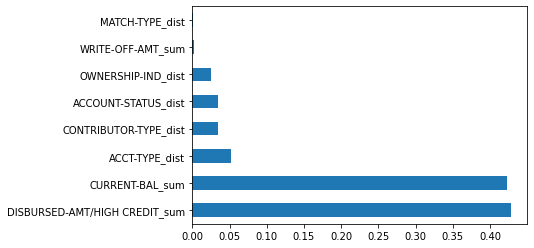

In [19]:
#Bureau plot 1
#Refer to https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e&client=ubuntu&hl=th&gl=th&strip=1&vwsrc=0
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
test_df = test_df.na.fill(value=0)
plot_df = test_df.select('DISBURSED-AMT/HIGH CREDIT_sum','CURRENT-BAL_sum','WRITE-OFF-AMT_sum','MATCH-TYPE_dist','CONTRIBUTOR-TYPE_dist','OWNERSHIP-IND_dist','ACCOUNT-STATUS_dist','ACCT-TYPE_dist','Top-up').toPandas()
X = plot_df.iloc[:,:8]  #independent columns 
y = plot_df.iloc[:,-1]  #target column is Top-up
model = DecisionTreeClassifier()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

The above plot is showing the most important feature of the bureau dataframe by using the Decision Tree model. It can be seen that the two highest important feature is CURRENT_BAL_sum and DISBURSED-AMT/HIGH CREDIT_sum. The least important feature is MATCH-TYPE_dist.

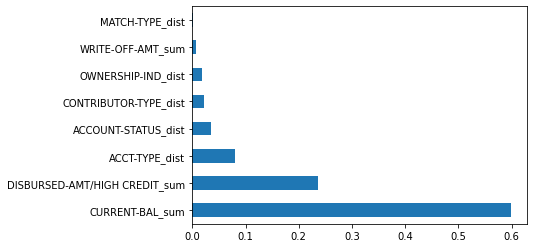

In [20]:
#Bureau plot 2
model = GradientBoostingClassifier()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

The above plot is showing the most important feature of the bureau dataframe by using the Gradient Boosted Tree model. It can be seen that the most important feature similar to the Decision Tree model is CURRENT-BAL_sum and the least important feature is MATCH-TYPE_dist.

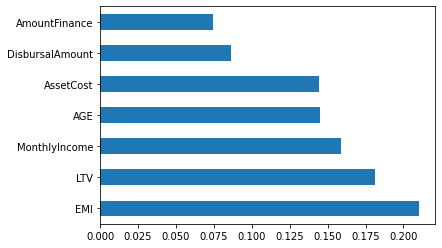

In [21]:
#Customer plot 1
plot_df = test_df.select('AGE','MonthlyIncome','AssetCost','AmountFinance','DisbursalAmount','EMI','LTV','Top-up').toPandas()
X = plot_df.iloc[:,:7]  #independent columns
y = plot_df.iloc[:,-1]    #target column is Top-ip

model = DecisionTreeClassifier()
model.fit(X,y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

The above plot is showing the most important feature of the customer dataframe by using the Decision Tree model. It can be seen that the most important feature is EMI and the least important feature are DisbursalAmount and AmountFinance. However, every feature score is close more than bureau dataframe.

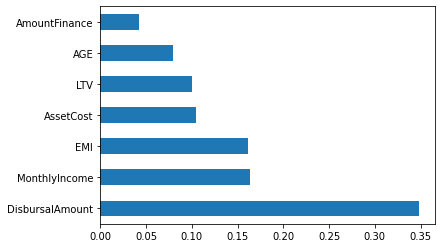

In [22]:
#Customer plot 2
model = GradientBoostingClassifier()
model.fit(X,y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

The above plot is showing the most important feature of the customer dataframe by using the Gradient Boosted model. It can be seen that the most important feature is not EMI but it is DisbursalAmount instead. Which is the opposite of the Decision Tree model. The least important feature are Age and AmountFinance.

In [23]:
#2.1.1
#Random splilt the dataset by 80% and 20% 
train, test = inner_df.randomSplit([0.8, 0.2],seed = 12515)
#2.1.2
#Create sample 20% / Top-up and non Top-up row 1:2 ratio
trainSample = train.sampleBy('Top-up', fractions={ '0': 0.141274, '1': 0.2 }, seed = 1314)
trainSample.groupBy('Top-up').count().show()

+------+-----+
|Top-up|count|
+------+-----+
|     0|10222|
|     1| 5111|
+------+-----+



In [24]:
#2.2.1
categoryInputCols = [ 'SEX', 'City',
 'Frequency',
 'LoanStatus']
numericInputCols = ['DISBURSED-AMT/HIGH CREDIT_sum',
 'CURRENT-BAL_sum',
 'ACCT-TYPE_dist',
 'Tenure',
 'AssetCost',
 'AmountFinance',
 'DisbursalAmount',
 'EMI',
 'LTV',
 'AGE',
 'MonthlyIncome']
categoryOutputCol = 'Top-up'
categoryCols = categoryInputCols+[categoryOutputCol]

First, I remove the ID and date column which are 'ID','MaturityDAte','AuthDate','AssetID','ManufacturerID' and 'SupplierID'. From the above data exploration include all of the feature columns from Bureau plot1 and plot2 but remove very low score columns which are 'WRITE-OFF-AMT_sum','MATCH-TYPE_dist', 'CONTRIBUTOR-TYPE_dist', and 'OWNERSHIP-IND_dist'. Add feature column from customer plot1 and plot2 which are 'AssetCost', 'AmountFinance','DisbursalAmount','EMI', 'AGE','Tenure', 'LTV' and 'MonthlyIncome'. Because the score is close to each other. I also add some personal characteristics of data such as 'SEX', 'City', 'Frequency' and, 'LoanStatus.

In [25]:
#2.2.2
#Fill null data as 0
trainSample = trainSample.na.fill(value=0)
test = test.na.fill(value=0)

trainSample = trainSample.withColumn("Frequency", when(trainSample["Frequency"] == "Monthly","0") \
      .when(trainSample["Frequency"] == "BI-Monthly","1") \
      .when(trainSample["Frequency"] == "Quatrly","2") \
      .when(trainSample["Frequency"] == "Half Yearly","3")         
      .otherwise(trainSample["Frequency"]))
trainSample = trainSample.withColumn("Frequency",trainSample.Frequency.cast(IntegerType()))

test = test.withColumn("Frequency", when(test["Frequency"] == "Monthly","0") \
      .when(test["Frequency"] == "BI-Monthly","1") \
      .when(test["Frequency"] == "Quatrly","2") \
      .when(test["Frequency"] == "Half Yearly","3")         
      .otherwise(test["Frequency"]))
test = test.withColumn('Frequency', col('Frequency').cast('integer'))

In [26]:
#2.2.2
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier
from pyspark.ml import Pipeline
outputCols=[f'{x}_index' for x in categoryInputCols]
outputCols.append('label')
#Change category columns to numberic column
#Refer to https://stackoverflow.com/questions/57143187/failed-to-execute-user-defined-functionanonfun9-string-double-on-using
inputIndexer = StringIndexer(inputCols=categoryCols, outputCols=outputCols).setHandleInvalid("keep")

inputCols_OHE = [x for x in outputCols if x!='label']
outputCols_OHE = [f'{x}_vec' for x in categoryInputCols]
encoder = OneHotEncoder(inputCols=inputCols_OHE,outputCols=outputCols_OHE)

inputCols=outputCols_OHE
assemblerInputs = outputCols_OHE + numericInputCols
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")

#Create DecisionTreeClassifier and GBTClassifier model
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 5 )
gt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 5)

In [27]:
%%time
#2.3.1
#Fit the dataset into the DecisionTree pipeline 
pipeline = Pipeline(stages=[inputIndexer, encoder, assembler,dt])
pipelineModel1 = pipeline.fit(trainSample)
dtprediction = pipelineModel1.transform(test)
dtprediction.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|19354|
|       1.0| 4517|
+----------+-----+

CPU times: user 17.6 ms, sys: 15.9 ms, total: 33.5 ms
Wall time: 46.4 s


In [28]:
%%time
#Fit the dataset into the Gradient Boosted Tree pipeline 
pipeline = Pipeline(stages=[inputIndexer, encoder, assembler,gt])
pipelineModel2 = pipeline.fit(trainSample)
gtprediction = pipelineModel2.transform(test)
gtprediction.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|20054|
|       1.0| 3817|
+----------+-----+

CPU times: user 44.6 ms, sys: 4.76 ms, total: 49.4 ms
Wall time: 2min 26s


In [29]:
#2.3.2
#Display combination of Top-up and prediction of DecisionTree pipeline 
dtprediction.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1982|
|  0.0|       1.0| 2535|
|  1.0|       0.0| 4163|
|  0.0|       0.0|15191|
+-----+----------+-----+



In [30]:
#Display combination of Top-up and prediction of Gradient Boosted Tree pipeline
gtprediction.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 2066|
|  0.0|       1.0| 1751|
|  1.0|       0.0| 4079|
|  0.0|       0.0|15975|
+-----+----------+-----+



In [31]:
#2.3.3
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Compute the AUC of DecisionTree
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
auc_dt = evaluator.evaluate(dtprediction)
print('DecisionTree')
print(auc_dt)
print(evaluator.getMetricName())

DecisionTree
0.5897641909522836
areaUnderROC


In [32]:
#Compute the AUC of Gradient Boosted Tree
auc_gt = evaluator.evaluate(gtprediction)
print('Gradient Boosted Tree')
print(auc_gt)
print(evaluator.getMetricName())

Gradient Boosted Tree
0.6187134242272319
areaUnderROC


In [33]:
#Compute the accuracy, recall and presicion
def compute_metrics(predictions):
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()
    FP = predictions.filter('prediction = 1 AND label = 0').count()
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)

    return accuracy,precision,recall
#Display accuracy, recall and presicion of DecisionTree
print('DecisionTree')
print(compute_metrics(dtprediction))
#Display accuracy, recall and presicion of Gradient Boosted Tree
print('Gradient Boosted Tree')
print(compute_metrics(gtprediction))

DecisionTree
(0.719408487285828, 0.43878680540181536, 0.3225386493083808)
Gradient Boosted Tree
(0.7557706003099995, 0.5412627718103222, 0.33620829943043123)


It can be seen that every score of Gradient Boosted Tree is better than DecisionTree such as accuracy precision and recall. but The loading time of Gradient Boosted Tree is taking longer than DecisionTree model even though the depth and number of feature column are equal between two models.

In [34]:
#2.3.4
#Select the feature column and target column
test_dataframe = gtprediction.select('SEX_index', 'City_index', 'Frequency_index', 'LoanStatus_index','DISBURSED-AMT/HIGH CREDIT_sum',
 'CURRENT-BAL_sum',
 'ACCT-TYPE_dist',
 'Tenure',
 'AssetCost',
 'AmountFinance',
 'DisbursalAmount',
 'EMI',
 'LTV',
 'AGE',
 'MonthlyIncome','label').toPandas()

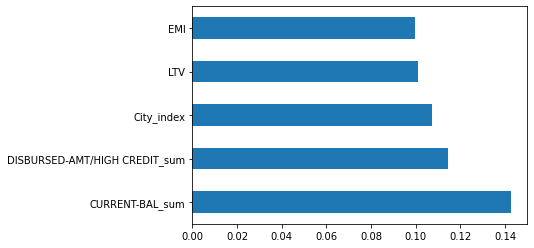

In [35]:
from sklearn.tree import DecisionTreeClassifier
#Display the top 5 most important feature of DecisionTree
X = test_dataframe.iloc[:,:15]  #feature column
y = test_dataframe.iloc[:,-1]    #target column is label
model = DecisionTreeClassifier()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

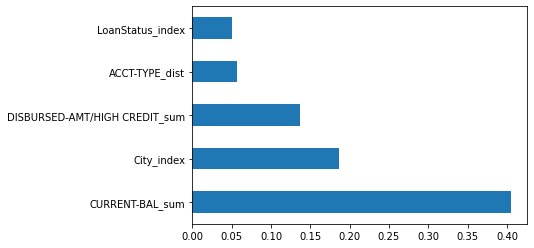

In [36]:
#Display the top 5 most important feature of Gradient Boosted Tree
model = GradientBoostingClassifier()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

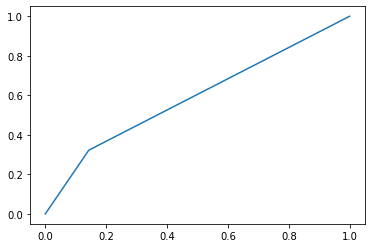

In [37]:
#Plot ROC curve of DecisionTree
#Refer to https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
dtprediction_pd = dtprediction.toPandas()
y1= dtprediction_pd['label']
y2 = dtprediction_pd['prediction']
fpr, tpr, thresholds = metrics.roc_curve(y1,y2, pos_label = 0)
plt.plot(tpr,fpr)
plt.show()

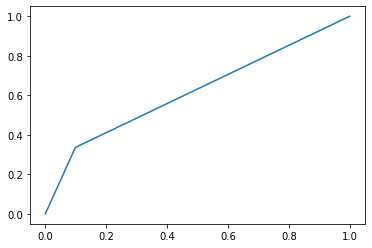

In [38]:
#Plot ROC curve of Gradient Boosted Tree
gtprediction_pd= gtprediction.toPandas()
y1= gtprediction_pd['label']
y2 = gtprediction_pd['prediction']
fpr, tpr, thresholds = metrics.roc_curve(y1,y2, pos_label = 0)
plt.plot(tpr,fpr)
plt.show()

In [39]:
#2.3.5
#Ratio top-up and non-top up by 1:2
trainSample = train.sampleBy('Top-up', fractions={ '0': 0.7033, '1': 1 },seed =123)
trainSample = trainSample.withColumn("Frequency", when(trainSample["Frequency"] == "Monthly","0") \
      .when(trainSample["Frequency"] == "BI-Monthly","1") \
      .when(trainSample["Frequency"] == "Quatrly","2") \
      .when(trainSample["Frequency"] == "Half Yearly","3")         
      .otherwise(trainSample["Frequency"]))

trainSample = trainSample.withColumn("Frequency",trainSample.Frequency.cast(IntegerType()))
trainSample.groupBy('Top-up').count().show()

+------+-----+
|Top-up|count|
+------+-----+
|     0|50722|
|     1|25361|
+------+-----+



In [40]:
%%time
#Fit the dataset into the DecisionTree pipeline 
pipeline1 = Pipeline(stages=[inputIndexer, encoder, assembler,dt])
pipelineModel1 = pipeline1.fit(trainSample)
dtprediction = pipelineModel1.transform(test)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print('DecisionTree')
print(auc_dt)
print(evaluator.getMetricName())

DecisionTree
0.5897641909522836
areaUnderROC
CPU times: user 29.7 ms, sys: 4.42 ms, total: 34.1 ms
Wall time: 37.8 s


In [41]:
%%time
#Fit the dataset into the Gradient Boosted Tree pipeline 
pipeline = Pipeline(stages=[inputIndexer, encoder, assembler,gt])
pipelineModel2 = pipeline.fit(trainSample)
gtprediction = pipelineModel2.transform(test)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print('Gradient Boosted Tree')
print(auc_gt)
print(evaluator.getMetricName())

Gradient Boosted Tree
0.6187134242272319
areaUnderROC
CPU times: user 47.6 ms, sys: 13.2 ms, total: 60.8 ms
Wall time: 2min 44s


In [42]:
print('DecisionTree')
print(compute_metrics(dtprediction))
print('Gradient Boosted Tree')
print(compute_metrics(gtprediction))

DecisionTree
(0.7413179171379498, 0.4961967545638945, 0.3184703010577705)
Gradient Boosted Tree
(0.7582422185915965, 0.5468202303455183, 0.35541090317331164)


The better model is still Gradient Boosted Tree model.

In [43]:
#Save the better models
pipelineModel2.write().overwrite().save('bestmodel')

In [44]:
#3,1
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
test_df = spark.createDataFrame([[0, 35.3, 37.5],[1, 41.4, -23.5],[2, 28.3, -13.3],[3, 09.5, -9.0],[4, 62.8, -18.23],[5, 63.8, -18.33],[6, 82.8, -17.23],[7, 52.8, -13.43],[8, 72.8, 48.23],[9, 65.8, 15.43],[10, 42.8, -13.23] ],["ID","Att_1", "Att_2"])
assembler = VectorAssembler(inputCols=["Att_1", "Att_2"],outputCol='features')
kmeans = KMeans(k=4).fit(assembler.transform(test_df))

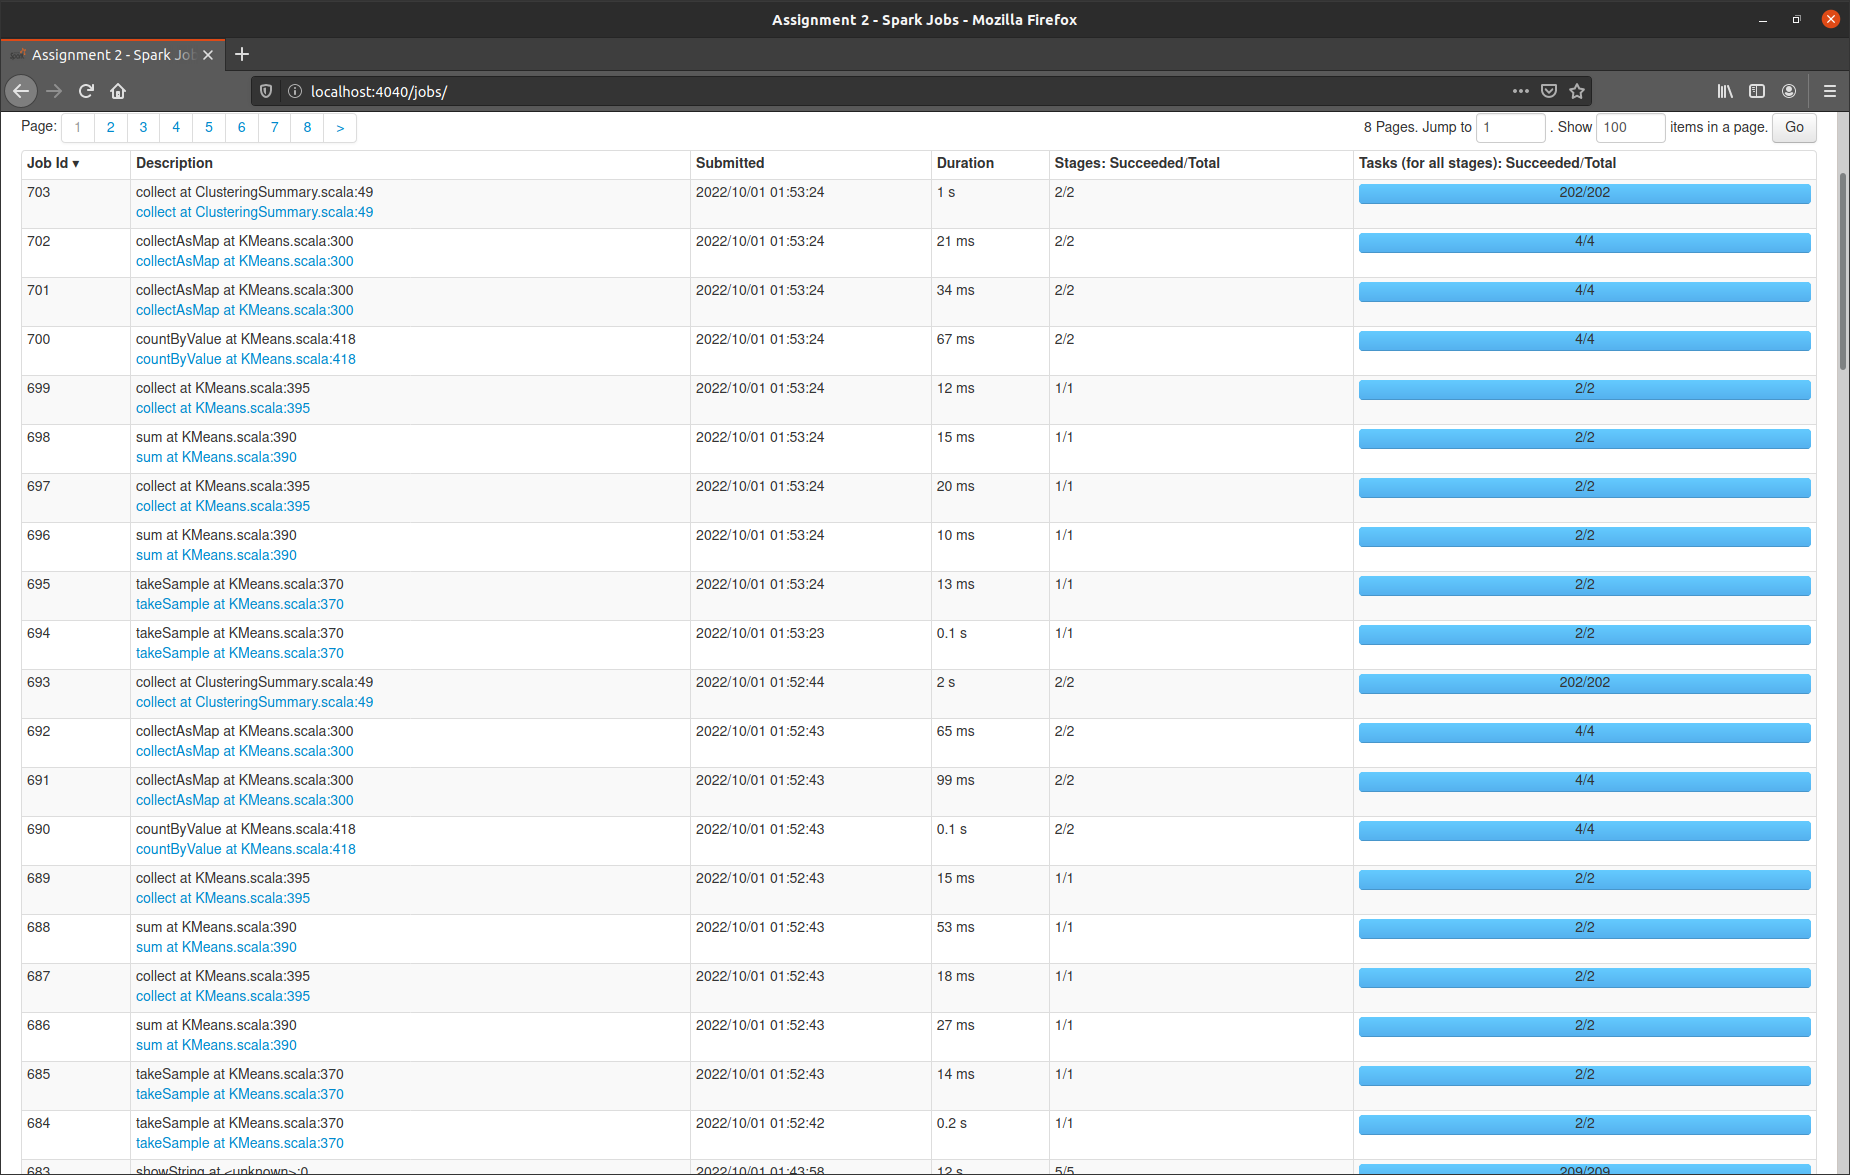


It take 20 jobs to training the KMeans.

3.2
The spark will start with a random center and then pass more centers with probability proportional to their squared distance to the current cluster set. So the result will be a provable approximation to an optimal clustering. If the number of centers more than 'k'. The spark will recalculate the process.